In [1]:
import json
import re
from html import unescape
from pathlib import Path
import spacy

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd


# --- Text cleaning (anf_text contains HTML) ---
_TAG_RE = re.compile(r"<[^>]+>")
_WS_RE = re.compile(r"\s+")

def clean_anf_text(html_text: str) -> str:
    if not html_text:
        return ""
    s = html_text.replace("<br/>", "\n").replace("<br />", "\n").replace("</p>", "\n")
    s = unescape(s)
    s = _TAG_RE.sub(" ", s)          # remove tags
    s = _WS_RE.sub(" ", s).strip()   # normalize whitespace
    return s


def extract_anforanden_from_json(path: Path) -> pd.DataFrame:
    """Extract one row per anförande from one JSON file."""
    with path.open("r", encoding="utf-8") as f:
        data = json.load(f)

    anforanden = (
        data.get("dokumentstatus", {})
            .get("debatt", {})
            .get("anforande", [])
    )

    rows = []
    for a in anforanden:
        rows.append({
            "source_file": path.name,
            "debatt_titel": a.get("debatt_titel"),

            # speaker info
            "talare": a.get("talare"),
            "talare_id": a.get("intressent_id"),

            # existing metadata
            "parti": a.get("parti"),
            "kon": a.get("kon"),

            # speech text
            "text": clean_anf_text(a.get("anf_text")),
        })

    topic = anforanden[0]["debatt_titel"] if anforanden else None
    df = pd.DataFrame(rows)

    # Remove empty speeches
    df = df[df["text"].astype(str).str.len() > 0].reset_index(drop=True)
    return df, topic


# --------- LOAD ALL FILES FROM Project/data/ ----------
DATA_DIR = Path("data") 
json_files = sorted(DATA_DIR.glob("*.json"))

topics = []
dfs = []
for fp in json_files:
    try:
        df, topic = extract_anforanden_from_json(fp)
        topics.append(topic)
        dfs.append(df)
    except Exception as e:
        print(f"Skipping {fp.name}: {e}")

df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

print("Files:", len(json_files))
print("Speeches (anföranden):", len(df))
print("Topics:", len(topics))

df.head()


Skipping ha01au3.json: 'text'
Skipping ha01au4.json: 'text'
Skipping ha01cu17.json: 'text'
Skipping ha01cu20.json: 'text'
Skipping ha01cu3.json: 'text'
Skipping ha01cu4.json: Expecting ',' delimiter: line 1 column 79088 (char 79087)
Skipping ha01cu5.json: 'text'
Skipping ha01fiu10.json: 'text'
Skipping ha01fiu11.json: 'text'
Skipping ha01fiu13.json: 'text'
Skipping ha01fiu14.json: 'text'
Skipping ha01fiu15.json: 'text'
Skipping ha01fiu16.json: 'text'
Skipping ha01fiu17.json: 'text'
Skipping ha01fiu18.json: 'text'
Skipping ha01fiu19.json: 'text'
Skipping ha01fiu23.json: 'text'
Skipping ha01fiu28.json: 'str' object has no attribute 'get'
Skipping ha01fiu29.json: 'text'
Skipping ha01fiu30.json: 'text'
Skipping ha01fiu36.json: 'str' object has no attribute 'get'
Skipping ha01fiu37.json: 'text'
Skipping ha01fiu39.json: 'text'
Skipping ha01fiu4.json: 'text'
Skipping ha01fiu40.json: 'text'
Skipping ha01fiu42.json: 'text'
Skipping ha01fiu7.json: 'str' object has no attribute 'get'
Skipping ha0

,source_file,debatt_titel,talare,talare_id,parti,kon,text
0,ha01au1.json,Utgiftsområde 13 Jämställdhet och nyanlända in...,Michael Rubbestad (SD),6025366f-76b8-4664-a3ef-ea0864fc8365,SD,male,Fru talman! Sverige är ett av världens mest jä...
1,ha01au1.json,Utgiftsområde 13 Jämställdhet och nyanlända in...,Sofia Amloh (S),359e75f3-519e-49d7-b155-ada488e621ea,S,female,Fru talman! Jag tänkte ta tillfället i akt att...
2,ha01au1.json,Utgiftsområde 13 Jämställdhet och nyanlända in...,Michael Rubbestad (SD),6025366f-76b8-4664-a3ef-ea0864fc8365,SD,male,"Fru talman! Tack, Sofia Amloh, för frågan! Det..."
3,ha01au1.json,Utgiftsområde 13 Jämställdhet och nyanlända in...,Sofia Amloh (S),359e75f3-519e-49d7-b155-ada488e621ea,S,female,Fru talman! Jag tror att det har varit ganska ...
4,ha01au1.json,Utgiftsområde 13 Jämställdhet och nyanlända in...,Michael Rubbestad (SD),6025366f-76b8-4664-a3ef-ea0864fc8365,SD,male,"Fru talman! Ta ansvar, säger ledamoten från So..."


In [6]:
output = []
for topic in topics:
    if topic not in output:
        output.append(topic)

for topic in output:
    print(topic)

topics = output


Utgiftsområde 13 Jämställdhet och nyanlända invandrares etablering
En fortsatt stärkt arbetslöshetsförsäkring
Utgiftsområde 14 Arbetsmarknad och arbetsliv
Arbetsrätt
Integration
Jämställdhet och åtgärder mot diskriminering
Arbetsmiljö och arbetstid
Arbetsmarknadspolitik och arbetslöshetsförsäkringen
Utgiftsområde 18 Samhällsplanering, bostadsförsörjning och byggande samt konsumentpolitik
Bostadspolitik
Associationsrätt
Planering och byggande
Hushållningen med mark- och vattenområden
Hyresrätt m.m.
Ändringar i jordförvärvslagen i syfte att hindra att bestämmelserna om förvärvstillstånd kringgås
Möjligheten till tidsbegränsade bygglov för bostäder förlängs
EU:s nya tågpassagerarförordning
Ökad transparens för stora företags skattebetalningar
Ett oberoende tvistlösningsförfarande för kollektiva hyrestvister
Familjerätt
Ersättningsrätt samt insolvens- och utsökningsrätt
Konsumenträtt
Fastighetsrätt
Statens budget 2023 ? Rambeslutet
Riksrevisionens rapport om den årliga omräkningen av myndi

In [ ]:


topic_ids = [344, 158, 159, 160, 162, 163, 164, 345, 466]          
selected_topics = [topics[i] for i in topic_ids]

import re
pattern = "|".join(map(re.escape, selected_topics))

df_topic = df[
    df["debatt_titel"].str.contains(pattern, case=False, na=False)
].copy()

print("Topics:", *selected_topics)
print("Anföranden in topics:", len(df_topic))

df_topic = df_topic[
    ["talare_id", "parti", "kon", "text"]
]

df_topic.head()


Topics: Utgiftsområde 3 Skatt, tull och exekution Ny mervärdesskattelag Inkomstskatt Skatteförfarande Punktskatt och tull Mervärdesskatt
Anföranden in topics: 322


,talare_id,parti,kon,text
3542,f3da7403-18a0-454d-bcac-9a0a36783d38,SD,male,Fru talman! Jag vill börja med att yrka bifall...
3543,ed3399e1-7bce-4ea4-baf6-587f722710f5,S,female,"Fru talman! Jag är socialdemokrat, och för oss..."
3544,d3628aa4-ea6a-4466-8e2c-f3d0cb2d9cad,M,female,Fru talman! Jag vill tacka Hanna Westerén för ...
3545,ed3399e1-7bce-4ea4-baf6-587f722710f5,S,female,"Fru talman! Tack för frågan, Boriana Åberg! Vi..."
3546,d3628aa4-ea6a-4466-8e2c-f3d0cb2d9cad,M,female,Fru talman! Förutom de 75 miljoner som har avs...


In [76]:
nlp = spacy.load("sv_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join(
        token.lemma_
        for token in doc
        if not token.is_stop and not token.is_punct
    )

# apply to dataframe
df_topic["text_lem"] = df_topic["text"].astype(str).apply(lemmatize_text)

df_topic = df_topic[[
    "talare_id",
    "parti",
    "kon",
    "text",
    "text_lem"
]]

df_topic.head()

,talare_id,parti,kon,text,text_lem
3542,f3da7403-18a0-454d-bcac-9a0a36783d38,SD,male,Fru talman! Jag vill börja med att yrka bifall...,Fru talman börja yrka bifall utskott förslag v...
3543,ed3399e1-7bce-4ea4-baf6-587f722710f5,S,female,"Fru talman! Jag är socialdemokrat, och för oss...",Fru talman vara socialdemokrat socialdemokrat ...
3544,d3628aa4-ea6a-4466-8e2c-f3d0cb2d9cad,M,female,Fru talman! Jag vill tacka Hanna Westerén för ...,Fru talman tacka Hanna Westerén anförande hann...
3545,ed3399e1-7bce-4ea4-baf6-587f722710f5,S,female,"Fru talman! Tack för frågan, Boriana Åberg! Vi...",Fru talman fråga Boriana Åberg vara mån överen...
3546,d3628aa4-ea6a-4466-8e2c-f3d0cb2d9cad,M,female,Fru talman! Förutom de 75 miljoner som har avs...,Fru talman förutom 75 miljon avsata år avsata ...


In [77]:
from transformers import pipeline

sentiment_model = pipeline(
    "text-classification",
    model="KBLab/robust-swedish-sentiment-multiclass",
    truncation=True,   
    max_length=512     
)

def get_sentiments(texts, batch_size=16):
    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        out = sentiment_model(batch)  # truncation happens automatically
        results.extend(r["label"] for r in out)
    return results

df_topic["sentiment"] = get_sentiments(df_topic["text_lem"].tolist())

Device set to use cpu


In [55]:
df_topic.head()

,talare_id,parti,kon,text,text_lem,sentiment
3542,f3da7403-18a0-454d-bcac-9a0a36783d38,SD,male,Fru talman! Jag vill börja med att yrka bifall...,Fru talman börja yrka bifall utskott förslag v...,NEUTRAL
3543,ed3399e1-7bce-4ea4-baf6-587f722710f5,S,female,"Fru talman! Jag är socialdemokrat, och för oss...",Fru talman vara socialdemokrat socialdemokrat ...,POSITIVE
3544,d3628aa4-ea6a-4466-8e2c-f3d0cb2d9cad,M,female,Fru talman! Jag vill tacka Hanna Westerén för ...,Fru talman tacka Hanna Westerén anförande hann...,POSITIVE
3545,ed3399e1-7bce-4ea4-baf6-587f722710f5,S,female,"Fru talman! Tack för frågan, Boriana Åberg! Vi...",Fru talman fråga Boriana Åberg vara mån överen...,NEUTRAL
3546,d3628aa4-ea6a-4466-8e2c-f3d0cb2d9cad,M,female,Fru talman! Förutom de 75 miljoner som har avs...,Fru talman förutom 75 miljon avsata år avsata ...,NEUTRAL


In [78]:
sentiment_map = {
    "NEGATIVE": -1,
    "NEUTRAL": 0,
    "POSITIVE": 1
}

df_topic["sentiment_1_5"] = df_topic["sentiment"].map(sentiment_map)

grouped_speaker = (
    df_topic
    .groupby("talare_id")
    .agg(
        mean_sentiment=("sentiment_1_5", "mean"),
        n_anf=("sentiment_1_5", "count"),
        parti=("parti", "first"),
        kon=("kon", "first"),
    )
    .reset_index()
    .sort_values("mean_sentiment", ascending=False)
)

grouped_speaker.head()

,talare_id,mean_sentiment,n_anf,parti,kon
36,ed3399e1-7bce-4ea4-baf6-587f722710f5,0.428571,7,S,female
22,94366ec1-ba40-44b2-b98f-8676fccbcd4d,0.333333,3,C,male
10,6225d351-aa7a-4a12-94a0-084b7077a7af,0.136364,22,KD,female
1,0a518d5d-b7c9-41bd-ba06-c2d09a873ed4,0.000000,4,SD,male
4,24c753af-11ea-4c6f-90f9-f4142fc71e19,0.000000,2,SD,male


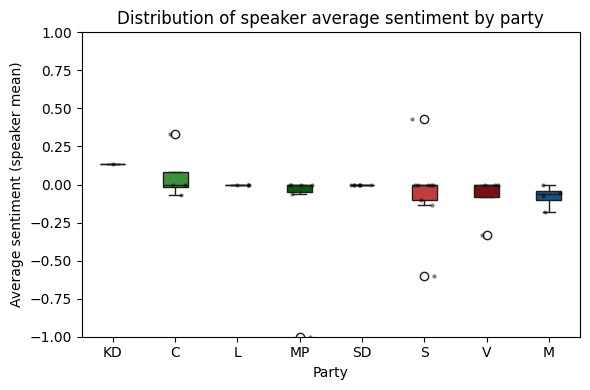

In [79]:
# Optional: filter out speakers with very few speeches (recommended)
#min_anf = 3
#plot_df = grouped_speaker[grouped_speaker["n_anf"] >= min_anf].copy()

party_palette = {
    "L":  "#9ecae1",   # light blue
    "M":  "#08519c",   # dark blue
    "MP": "#006400",   # dark green
    "C":  "#2ca02c",   # green
    "S":  "#d62728",   # red
    "V":  "#8b0000",   # dark red
    "SD": "#f1c40f",   # yellow
    "KD": "#1f77b4",   # blue
}

valid_parties = party_palette.keys()

grouped_speaker = grouped_speaker[
    grouped_speaker["parti"].isin(valid_parties)
]

# Optional: set party order by median (nice for readability)
party_order = (
    grouped_speaker.groupby("parti")["mean_sentiment"]
    .median()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(6, 4))

sns.boxplot(
    data=grouped_speaker,
    x="parti",
    y="mean_sentiment",
    hue="parti",              
    order=party_order,
    palette=party_palette,
    dodge=False,
    legend=False,    
    width=0.4        
)

sns.stripplot(
    data=grouped_speaker,
    x="parti",
    y="mean_sentiment",
    order=party_order,
    color="black",
    jitter=0.2,
    alpha=0.5,
    size=3
)

plt.xlabel("Party")
plt.ylabel("Average sentiment (speaker mean)")
plt.title("Distribution of speaker average sentiment by party")
plt.ylim(-1, 1)

plt.tight_layout()
plt.show()

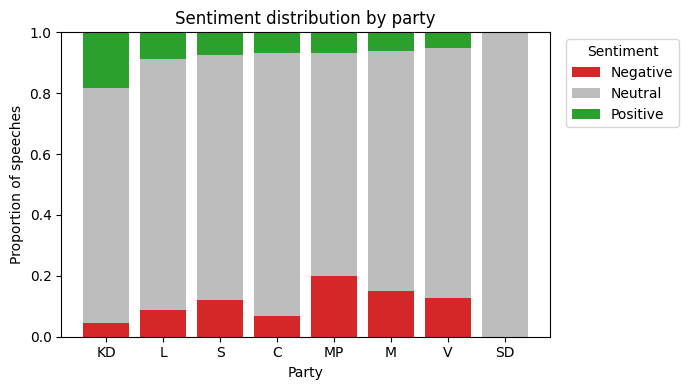

In [80]:
# Keep only parties you want
valid_parties = party_palette.keys()
df_plot = df_topic[df_topic["parti"].isin(valid_parties)].copy()

# Count sentiment categories per party
counts = (
    df_plot
    .groupby(["parti", "sentiment_1_5"])
    .size()
    .unstack(fill_value=0)
)

# Ensure all sentiment columns exist
counts = counts.reindex(columns=[-1, 0, 1], fill_value=0)

# Convert to proportions
proportions = counts.div(counts.sum(axis=1), axis=0)

# Optional: reorder parties (e.g. by positivity)
party_order = proportions[1].sort_values(ascending=False).index
proportions = proportions.loc[party_order]

sentiment_colors = {
    -1: "#d62728",  # red (negative)
     0: "#bdbdbd",  # gray (neutral)
     1: "#2ca02c"   # green (positive)
}

plt.figure(figsize=(7, 4))

bottom = pd.Series(0, index=proportions.index)

for sentiment in [-1, 0, 1]:
    plt.bar(
        proportions.index,
        proportions[sentiment],
        bottom=bottom,
        color=sentiment_colors[sentiment],
        label={-1: "Negative", 0: "Neutral", 1: "Positive"}[sentiment]
    )
    bottom += proportions[sentiment]

plt.ylabel("Proportion of speeches")
plt.xlabel("Party")
plt.title("Sentiment distribution by party")
plt.ylim(0, 1)

plt.legend(title="Sentiment", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [81]:
def party_outliers(df):
    rows = []

    for parti, g in df.groupby("parti"):
        high = g.loc[g["mean_sentiment"].idxmax()]
        low = g.loc[g["mean_sentiment"].idxmin()]

        rows.append({
            "parti": parti,
            "type": "highest",
            "talare_id": high["talare_id"],
            "kon": high["kon"],
            "mean_sentiment": high["mean_sentiment"],
            "n_anf": high["n_anf"],
        })

        rows.append({
            "parti": parti,
            "type": "lowest",
            "talare_id": low["talare_id"],
            "kon": low["kon"],
            "mean_sentiment": low["mean_sentiment"],
            "n_anf": low["n_anf"],
        })

    return pd.DataFrame(rows)

outliers_df = party_outliers(grouped_speaker)
outliers_df

,parti,type,talare_id,kon,mean_sentiment,n_anf
0,C,highest,94366ec1-ba40-44b2-b98f-8676fccbcd4d,male,0.333333,3
1,C,lowest,6cca7c48-b127-4d65-8052-ac3588a50dbd,female,-0.071429,14
2,KD,highest,6225d351-aa7a-4a12-94a0-084b7077a7af,female,0.136364,22
3,KD,lowest,6225d351-aa7a-4a12-94a0-084b7077a7af,female,0.136364,22
4,L,highest,75418838-bb8e-4b7b-964a-967085876d4b,male,0.000000,8
5,L,lowest,75418838-bb8e-4b7b-964a-967085876d4b,male,0.000000,8
6,M,highest,8c8b9102-1695-4533-a2a2-f95b98c63032,female,0.000000,12
7,M,lowest,392a2ddd-593e-430b-9181-794b99a1ec7c,male,-0.181818,22
8,MP,highest,209f7bbf-b8ec-4e57-81a0-35f17629212b,male,0.000000,1
9,MP,lowest,7e408079-a5cd-432a-a30e-fd61fd15c65a,female,-1.000000,3


In [82]:
lowest_gender_probs = (
    outliers_df[outliers_df["type"] == "lowest"]
    ["kon"]
    .value_counts(normalize=True)
)

highest_gender_probs = (
    outliers_df[outliers_df["type"] == "highest"]
    ["kon"]
    .value_counts(normalize=True)
)

prob_table = (
    outliers_df
    .groupby(["type", "kon"])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack()
)

prob_table

,kon,female,male
type,type,,
highest,highest,0.5,0.5
lowest,lowest,0.5,0.5
